# Вариант 4. Данные по инсультам

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import featuretools as ft
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

df = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")

print(df.columns)
df.head()

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

# Бизнес цели и цели технического проекта.
## Бизнес цели:
### 1. Предсказание инсульта: Разработать систему, которая сможет предсказать вероятность инсульта у пациентов на основе их медицинских и социальных данных. Это может помочь медицинским учреждениям и специалистам в более раннем выявлении пациентов с высоким риском.
### 2. Снижение затрат на лечение: Предупреждение инсультов у пациентов позволит снизить затраты на лечение и реабилитацию. Это также поможет улучшить качество медицинских услуг и повысить удовлетворенность пациентов.
### 3. Повышение эффективности профилактики: Выявление факторов риска инсульта на ранней стадии может способствовать более эффективному проведению профилактических мероприятий.
## Цели технического проекта:
### 1. Создание и обучение модели машинного обучения: Разработка модели, способной предсказать вероятность инсульта на основе данных о пациентах (например, возраст, уровень глюкозы, наличие сердечно-сосудистых заболеваний, тип работы, индекс массы тела и т.д.).
### 2. Анализ и обработка данных: Провести предобработку данных (очистка, заполнение пропущенных значений, кодирование категориальных признаков), чтобы улучшить качество и надежность модели.
### 3. Оценка модели: Использовать метрики, такие как точность, полнота и F1-мера, чтобы оценить эффективность модели и минимизировать риск ложных положительных и ложных отрицательных предсказаний.

In [32]:
print(df.isnull().sum())
print()

print(df.isnull().any())
print()

for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f"{i} процент пустых значений: %{null_rate:.2f}")

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

bmi процент пустых значений: %3.93


### Видим пустые значения в bmi, заменяем их

In [33]:
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

missing_values = df.isnull().sum()

print("Количество пустых значений в каждом столбце после замены:")
print(missing_values)

Количество пустых значений в каждом столбце после замены:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [34]:
df = df.drop('id', axis = 1)
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')


### Создаем выборки

In [35]:
# Разделим данные на признак (X) и переменую (Y)
# Начнем со stroke
X = df.drop(columns=['stroke'])
y = df['stroke']

# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Разбиваем на обучающую и контрольную выборки
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

print("Размер обучающей выборки: ", X_train.shape)
print("Размер контрольной выборки: ", X_val.shape)
print("Размер тестовой выборки: ", X_test.shape)

Размер обучающей выборки:  (2503, 10)
Размер контрольной выборки:  (1074, 10)
Размер тестовой выборки:  (1533, 10)


### Оценим сбалансированность сборок

Распределение классов в обучающей выборке:
stroke
0    0.94966
1    0.05034
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
stroke
0    0.946927
1    0.053073
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
stroke
0    0.956947
1    0.043053
Name: proportion, dtype: float64


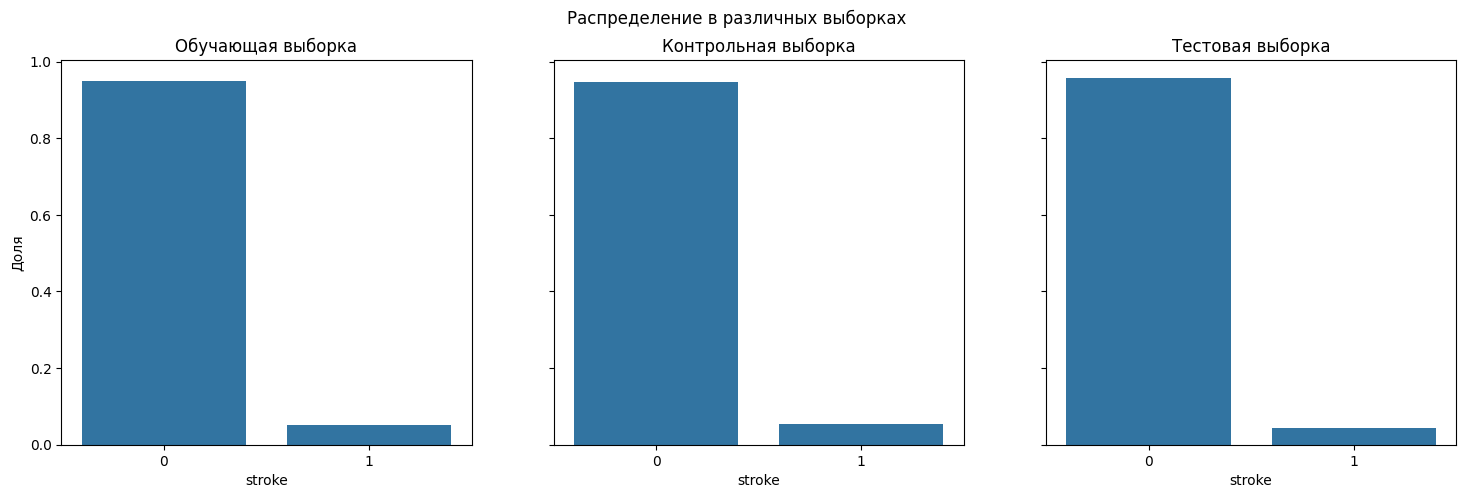

In [36]:
from locale import normalize


def analyze_balance(y_train, y_val, y_test, y_name):
    print("Распределение классов в обучающей выборке:")
    print(y_train.value_counts(normalize=True))

    print("\nРаспределение классов в контрольной выборке:")
    print(y_val.value_counts(normalize=True))

    print("\nРаспределение классов в тестовой выборке:")
    print(y_test.value_counts(normalize=True))

    fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
    fig.suptitle('Распределение в различных выборках')

    sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts(normalize=True), ax=axes[0])
    axes[0].set_title('Обучающая выборка')
    axes[0].set_xlabel(y_name)
    axes[0].set_ylabel('Доля')

    sns.barplot(x=y_val.value_counts().index, y=y_val.value_counts(normalize=True), ax=axes[1])
    axes[1].set_title('Контрольная выборка')
    axes[1].set_xlabel(y_name)

    sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts(normalize=True), ax=axes[2])
    axes[2].set_title('Тестовая выборка')
    axes[2].set_xlabel(y_name)

    plt.show()

analyze_balance(y_train, y_val, y_test, 'stroke')

Заметим, что выборки не сбалансированы. Для балансировки будем использовать RandomOverSampler

Распределение классов в обучающей выборке:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Распределение классов в контрольной выборке:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
stroke
0    0.956947
1    0.043053
Name: proportion, dtype: float64


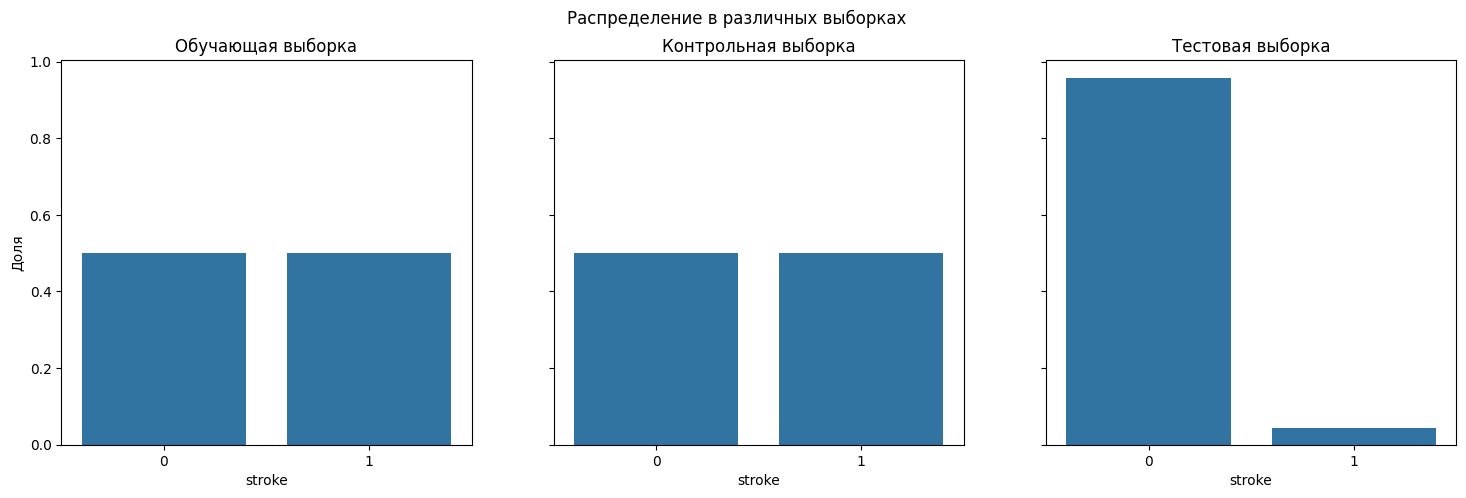

In [37]:
randoversamp = RandomOverSampler(random_state=42)

# Применение RandomOverSampler для балансировки выборок
X_train_resampled, y_train_resampled = randoversamp.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = randoversamp.fit_resample(X_val, y_val)

# Проверка сбалансированности после RandomOverSampler
analyze_balance(y_train_resampled, y_val_resampled, y_test, "stroke")

### Выборки сбалансированы

### Применим унитарное кодирование категориальных признаков (one-hot encoding), переведя их в бинарные вектора.

In [38]:
# Определение категориальных признаков
categorical_features = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]

# Применение one-hot encoding к обучающей выборке
X_train_encoded = pd.get_dummies(
    X_train_resampled, columns=categorical_features, drop_first=True
)

# Применение one-hot encoding к контрольной выборке
X_val_encoded = pd.get_dummies(
    X_val_resampled, columns=categorical_features, drop_first=True
)

# Применение one-hot encoding к тестовой выборке
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

print(X_train_encoded.head())

    age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0  67.0             0              0             190.70  36.0         True   
1  72.0             0              0              99.73  36.7         True   
2  74.0             1              1              70.09  27.4         True   
3  42.0             0              0              59.43  25.4        False   
4  60.0             0              0              69.53  26.2         True   

   ever_married_Yes  work_type_Never_worked  work_type_Private  \
0              True                   False               True   
1              True                   False              False   
2              True                   False               True   
3              True                   False              False   
4              True                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0                    False               False                

### Перейдем к числовым признакам, а именно к колонке age, применим дискретизацию (позволяет преобразовать данные из числового представления в категориальное):

In [39]:
# Определение числовых признаков для дискретизации
numerical_features = ["age"]


# Функция для дискретизации числовых признаков
def discretize_features(df, features, bins, labels):
    for feature in features:
        df[f"{feature}_bin"] = pd.cut(df[feature], bins=bins, labels=labels)
        df.drop(columns=[feature], inplace=True)
    return df


# Заданные интервалы и метки
age_bins = [0, 25, 55, 100]
age_labels = ["young", "middle-aged", "old"]

# Применение дискретизации к обучающей, контрольной и тестовой выборкам
X_train_encoded = discretize_features(
    X_train_encoded, numerical_features, bins=age_bins, labels=age_labels
)
X_val_encoded = discretize_features(
    X_val_encoded, numerical_features, bins=age_bins, labels=age_labels
)
X_test_encoded = discretize_features(
    X_test_encoded, numerical_features, bins=age_bins, labels=age_labels
)

print(X_train_encoded.head())

   hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0             0              0             190.70  36.0         True   
1             0              0              99.73  36.7         True   
2             1              1              70.09  27.4         True   
3             0              0              59.43  25.4        False   
4             0              0              69.53  26.2         True   

   ever_married_Yes  work_type_Never_worked  work_type_Private  \
0              True                   False               True   
1              True                   False              False   
2              True                   False               True   
3              True                   False              False   
4              True                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0                    False               False                  True   
1                     True

### Применим ручной синтез признаков. Например, в этом случае создадим признак, в котором вычисляется отклонение уровня глюкозы от среднего для определенной возрастной группы. Вышеуказанный признак может быть полезен для определения пациентов с аномальными данными.

In [40]:
age_glucose_mean = X_train_encoded.groupby("age_bin", observed=False)[
    "avg_glucose_level"
].transform("mean")
X_train_encoded["glucose_age_deviation"] = (
    X_train_encoded["avg_glucose_level"] - age_glucose_mean
)

age_glucose_mean = X_val_encoded.groupby("age_bin", observed=False)[
    "avg_glucose_level"
].transform("mean")
X_val_encoded["glucose_age_deviation"] = (
    X_val_encoded["avg_glucose_level"] - age_glucose_mean
)

age_glucose_mean = X_test_encoded.groupby("age_bin", observed=False)[
    "avg_glucose_level"
].transform("mean")
X_test_encoded["glucose_age_deviation"] = (
    X_test_encoded["avg_glucose_level"] - age_glucose_mean
)

print(X_train_encoded.head())

   hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0             0              0             190.70  36.0         True   
1             0              0              99.73  36.7         True   
2             1              1              70.09  27.4         True   
3             0              0              59.43  25.4        False   
4             0              0              69.53  26.2         True   

   ever_married_Yes  work_type_Never_worked  work_type_Private  \
0              True                   False               True   
1              True                   False              False   
2              True                   False               True   
3              True                   False              False   
4              True                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0                    False               False                  True   
1                     True

### Используем масштабирование признаков, для приведения всех числовых признаков к одинаковым или очень похожим диапазонам значений/распределениям. 
### Масштабирование признаков позволяет получить более качественную модель за счет снижения доминирования одних признаков над другими.

In [41]:
numerical_features = ["avg_glucose_level", "bmi", "glucose_age_deviation"]

scaler = StandardScaler()
X_train_encoded[numerical_features] = scaler.fit_transform(
    X_train_encoded[numerical_features]
)
X_val_encoded[numerical_features] = scaler.transform(X_val_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(
    X_test_encoded[numerical_features]
)

print(X_train_encoded.head())

   hypertension  heart_disease  avg_glucose_level       bmi  gender_Male  \
0             0              0           1.274173  0.891831         True   
1             0              0          -0.349199  0.991754         True   
2             1              1          -0.878129 -0.335787         True   
3             0              0          -1.068358 -0.621280        False   
4             0              0          -0.888122 -0.507083         True   

   ever_married_Yes  work_type_Never_worked  work_type_Private  \
0              True                   False               True   
1              True                   False              False   
2              True                   False               True   
3              True                   False              False   
4              True                   False              False   

   work_type_Self-employed  work_type_children  Residence_type_Urban  \
0                    False               False                  True   
1 

Сконструируем признаки, используя фреймворк Featuretools:

In [42]:
data = X_train_encoded.copy()  # Используем предобработанные данные

es = ft.EntitySet(id="patients")

es = es.add_dataframe(
    dataframe_name="strokes_data", dataframe=data, index="index", make_index=True
)

feature_matrix, feature_defs = ft.dfs(
    entityset=es, target_dataframe_name="strokes_data", max_depth=1
)

print(feature_matrix.head())

       hypertension  heart_disease  avg_glucose_level       bmi  gender_Male  \
index                                                                          
0                 0              0           1.274173  0.891831         True   
1                 0              0          -0.349199  0.991754         True   
2                 1              1          -0.878129 -0.335787         True   
3                 0              0          -1.068358 -0.621280        False   
4                 0              0          -0.888122 -0.507083         True   

       ever_married_Yes  work_type_Never_worked  work_type_Private  \
index                                                                
0                  True                   False               True   
1                  True                   False              False   
2                  True                   False               True   
3                  True                   False              False   
4                  

d:\Users\Leo\AppData\Local\pypoetry\Cache\virtualenvs\mai-S9i2J6c7-py3.12\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(


### Оценим качество набора признаков.

1. Предсказательная способность (для задачи классификации)
 - Метрики: Accuracy, Precision, Recall, F1-Score, ROC AUC
 - Методы: Обучение модели на обучающей выборке и оценка на валидационной и тестовой выборках.

2. Вычислительная эффективность
 - Методы: Измерение времени, затраченного на генерацию признаков и обучение модели.

3. Надежность
 - Методы: Кросс-валидация и анализ чувствительности модели к изменениям в данных.

4. Корреляция
 - Методы: Анализ корреляционной матрицы признаков и исключение мультиколлинеарных признаков.

5. Логическая согласованность
 - Методы: Проверка логической связи признаков с целевой переменной и интерпретация результатов модели.

In [43]:
X_train_encoded = pd.get_dummies(X_train_encoded, drop_first=True)
X_val_encoded = pd.get_dummies(X_val_encoded, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_encoded, drop_first=True)

all_columns = X_train_encoded.columns
X_train_encoded = X_train_encoded.reindex(columns=all_columns, fill_value=0)
X_val_encoded = X_val_encoded.reindex(columns=all_columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=all_columns, fill_value=0)

# Выбор модели
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Начинаем отсчет времени
start_time = time.time()
model.fit(X_train_encoded, y_train_resampled)

# Время обучения модели
train_time = time.time() - start_time

print(f"Время обучения модели: {train_time:.2f} секунд")

Время обучения модели: 0.55 секунд


In [44]:
# Получение важности признаков
importances = model.feature_importances_
feature_names = X_train_encoded.columns

# Сортировка признаков по важности
feature_importance = pd.DataFrame({"feature": feature_names, "importance": importances})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                           feature  importance
16                     age_bin_old    0.199473
3                              bmi    0.186638
14           glucose_age_deviation    0.172977
2                avg_glucose_level    0.171885
15             age_bin_middle-aged    0.037563
5                 ever_married_Yes    0.036580
4                      gender_Male    0.028419
0                     hypertension    0.025984
8          work_type_Self-employed    0.022772
10            Residence_type_Urban    0.022221
1                    heart_disease    0.020967
12     smoking_status_never smoked    0.017890
7                work_type_Private    0.016844
11  smoking_status_formerly smoked    0.015641
13           smoking_status_smokes    0.012366
9               work_type_children    0.011684
6           work_type_Never_worked    0.000096


Accuracy: 0.9465101108936725
Precision: 0.21428571428571427
Recall: 0.09090909090909091
F1 Score: 0.1276595744680851
ROC AUC: 0.5379562496126913
Cross-validated Accuracy: 0.988641983507665


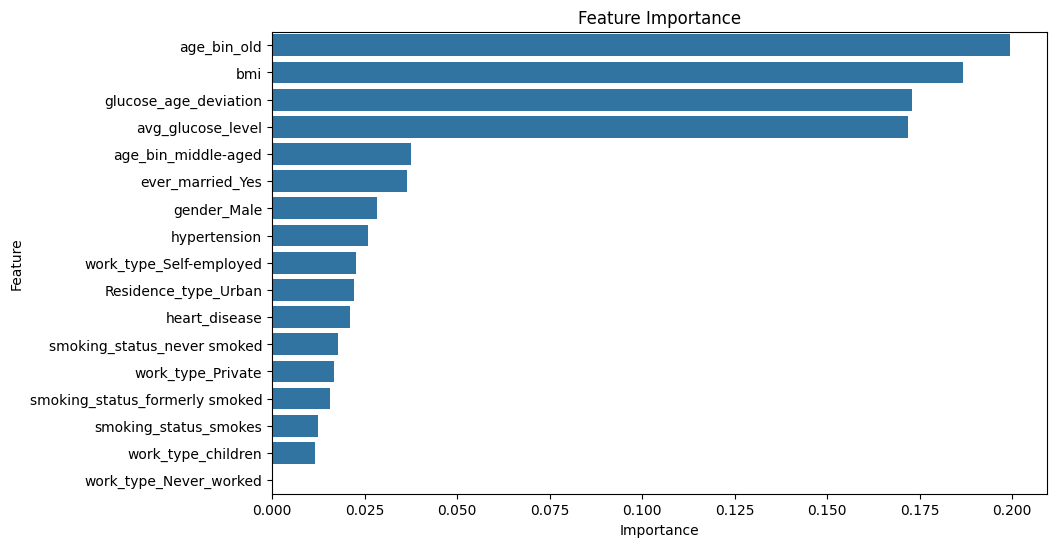

Train Accuracy: 1.0
Train Precision: 1.0
Train Recall: 1.0
Train F1 Score: 1.0
Train ROC AUC: 1.0


In [45]:
# Предсказание и оценка
y_pred = model.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Кросс-валидация
scores = cross_val_score(
    model, X_train_encoded, y_train_resampled, cv=5, scoring="accuracy"
)
accuracy_cv = scores.mean()
print(f"Cross-validated Accuracy: {accuracy_cv}")

# Анализ важности признаков
feature_importances = model.feature_importances_
feature_names = X_train_encoded.columns

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Feature Importance")
plt.show()

# Проверка на переобучение
y_train_pred = model.predict(X_train_encoded)

accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
precision_train = precision_score(y_train_resampled, y_train_pred)
recall_train = recall_score(y_train_resampled, y_train_pred)
f1_train = f1_score(y_train_resampled, y_train_pred)
roc_auc_train = roc_auc_score(y_train_resampled, y_train_pred)

print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Train ROC AUC: {roc_auc_train}")